# See Food v1

In [91]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
else:
  print(device)

cpu


## Load Data

In [18]:
labels_df = pd.read_csv('data/train_labels.csv')

n = 65
img_name = labels_df.iloc[n, 0]
labels = labels_df.iloc[n, 1:]
labels = np.asarray(labels)

print('Image name: {}'.format(img_name))
print('Label: {}'.format(labels))

Image name: train_66.jpg
Label: [39]


In [68]:
def show_image(image):
    """Show image"""
    plt.imshow(image)

# plt.figure()
# show_image(io.imread(os.path.join('data/train_set/train_set', img_name)))
# plt.show()

In [62]:
class FoodDataset(Dataset):
    """Food dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name)
        labels = self.labels_df.iloc[idx, 1:]
        labels = np.asarray(labels)
#         landmarks = np.array([landmarks])
#         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'landmarks': landmarks}

        sample = {'image': image, 'label': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (256, 384, 3) [21]
1 (256, 272, 3) [29]
2 (384, 256, 3) [17]
3 (256, 339, 3) [21]


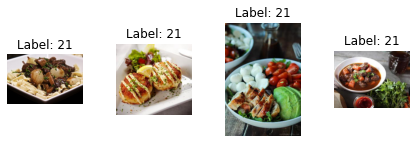

In [63]:
sample = FoodDataset(csv_file='data/train_labels.csv', root_dir='data/train_set/train_set/')

fig = plt.figure()

for i in range(len(food_dataset)):
    sample = food_dataset[i]
    
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
    ax.set_title('Label: {}'.format(label))
    ax.axis('off')
    show_image(**sample)

    if i == 3:
        plt.show()
        break

## Transforms

In [64]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

In [39]:
sample = food_dataset[65]
# print(sample['image'])
print(sample['label'])

[39]


In [42]:
sample = food_dataset[65]['image']
label = food_dataset[65]['label']
print(label)

[39]


In [43]:
sample, label =  food_dataset[65]['image'], food_dataset[65]['label']

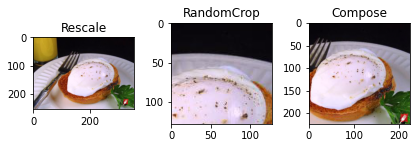

In [69]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = food_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_image(**transformed_sample)

plt.show()

In [70]:
transformed_dataset = FoodDataset(csv_file='data/train_labels.csv',
                                            root_dir='data/train_set/train_set/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

In [96]:
dataloader = DataLoader(transformed_dataset, batch_size=80,
                        shuffle=True, num_workers=0)

class_names = list(range(1,81))

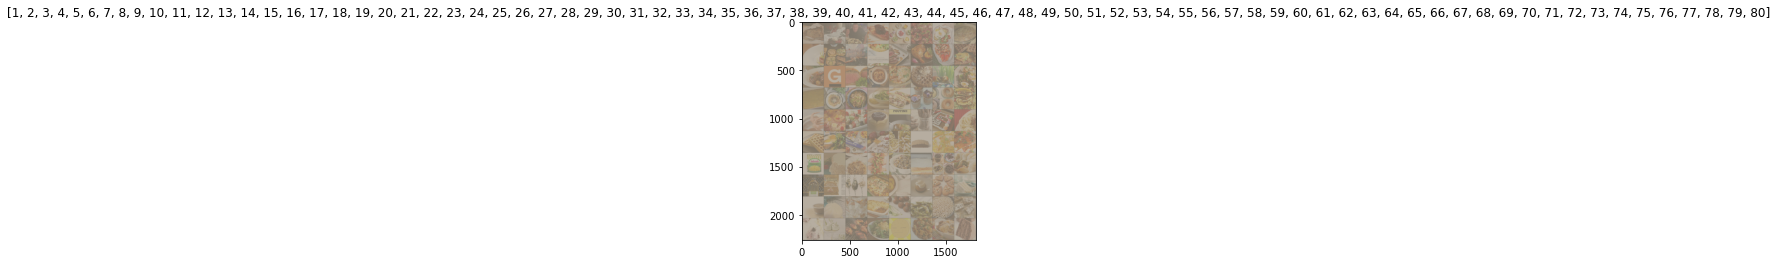

In [97]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs = next(iter(dataloader))
# inputs, classes = batch['image'], batch['labels']
# print(batch)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out, title=[class_names[x] for x in classes])

0 torch.Size([4, 3, 224, 224])
1 torch.Size([4, 3, 224, 224])
2 torch.Size([4, 3, 224, 224])
3 torch.Size([4, 3, 224, 224])


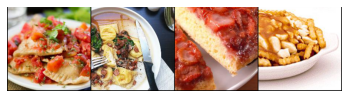

In [76]:

# Helper function to show a batch
def show_image_batch(sample_batched):
    """Show images for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

#     for i in range(batch_size):
#         plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
#                     landmarks_batch[i, :, 1].numpy() + grid_border_size,
#                     s=10, marker='.', c='r')

#     plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_image_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [84]:
list(range(1,81))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80]